In [1]:
### Imports ###

from sklearn.model_selection import train_test_split

from keras import models, layers
from keras.utils.np_utils import to_categorical

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

Using TensorFlow backend.


In [23]:
### Preprocess the data ###

df = pd.read_csv(os.getcwd() + '/res/athlete_events.csv')

# ID & Name are irrelevant to performance
# Games is covered by Year and Season
# We won't cover Event or City for now
df = df.drop(columns=['ID', 'Name', 'Event', 'Games', 'City'])

### Map all string values to int

# Start by gathering all values present in dataset

sports = df['Sport'].unique().tolist()
teams = df['Team'].unique().tolist()
nocs = df['NOC'].unique().tolist()
medals = ['Bronze', 'Silver', 'Gold']

# Map values to ints

# Note we're assuming anyone without a specified medal didn't get one (by filling NaN with 0).
# However, this might not be the case - some NaNs could correspond to missing data
df['Medal'] = df['Medal'].map(lambda m: medals.index(m) + 1, na_action='ignore').fillna(0)

df['Sex'] = df['Sex'].map(lambda s: 0 if s == 'F' else 1)
df['Season'] = df['Season'].map(lambda s: 0 if s == 'Summer' else 1)
df['Sport'] = df['Sport'].map(lambda s: sports.index(s))
df['Team'] = df['Team'].map(lambda t: teams.index(t))
df['NOC'] = df['NOC'].map(lambda c: nocs.index(c))

### Normalise data

# Where values are already in the range [-1, 1] we will leave the columns unchanged
# Otherwise, we will shift and scale to mean 0 and std 1
# Columnds Height and Weight are missing values. We will return to these

mean_and_std = {}  # store mean and std for each column for use in preprocessing future data
for col in ('Age', 'Team', 'NOC', 'Year', 'Sport'):
    mean = df[col].mean()
    std = df[col].std()
    mean_and_std[col] = (mean, std)
    df[col] -= mean
    df[col] /= std

# Fill NaNs for Height and Weight with 0, a number well outside the typical ranges
for col in ('Height', 'Weight'):
    df[col] = df[col].fillna(0)

# Scale Height and Weight to be in the range [0, 1]
df['Height'] /= 200
df['Weight'] /= 100

# Show dataframe for debugging
print(df)

# Split target column Medal, and ...
# Convert dataframes to numpy arrays
# Convert target values to categorical
y = to_categorical(df['Medal'].values)
X = df.drop(columns=['Medal']).values

# Train test split. We shuffle to reduce chance of bias caused by initial ordering of rows
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101, shuffle=True)

        Sex       Age  Height  Weight      Team       NOC      Year  Season  \
0         1 -0.243510   0.900    0.80 -0.708269 -1.099228  0.455910       0   
1         1 -0.399918   0.850    0.60 -0.708269 -1.099228  1.125307       0   
2         1 -0.243510   0.000    0.00 -0.698777 -1.078900 -1.953919       0   
3         1  1.320563   0.000    0.00 -0.689285 -1.078900 -2.623316       0   
4         0 -0.712732   0.925    0.82 -0.679793 -1.058572  0.322031       1   
5         0 -0.712732   0.925    0.82 -0.679793 -1.058572  0.322031       1   
6         0 -0.087103   0.925    0.82 -0.679793 -1.058572  0.455910       1   
7         0 -0.087103   0.925    0.82 -0.679793 -1.058572  0.455910       1   
8         0  0.225712   0.925    0.82 -0.679793 -1.058572  0.522850       1   
9         0  0.225712   0.925    0.82 -0.679793 -1.058572  0.522850       1   
10        1  0.851341   0.940    0.75 -0.670301 -1.038244  0.455910       1   
11        1  0.851341   0.940    0.75 -0.670301 -1.0

In [18]:
### Define network for single-label multiclass classification ###

model = models.Sequential()

# Width 8 layers used to prevent bottleneck with target dimension 4
model.add(layers.Dense(8, activation='relu', input_dim=9))
model.add(layers.Dense(8, activation='relu'))
# softmax width 4 for 4 medals
model.add(layers.Dense(4, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

hist = model.fit(X_train, y_train, epochs=20, batch_size=256, validation_split=0.2, shuffle=True)

Train on 145317 samples, validate on 36330 samples
Epoch 1/20
145317/145317 [==============================] - 1s 7us/step - loss: 0.8073 - acc: 0.8530 - val_loss: 0.5784 - val_acc: 0.8533
Epoch 2/20
145317/145317 [==============================] - 1s 6us/step - loss: 0.5768 - acc: 0.8538 - val_loss: 0.5783 - val_acc: 0.8533
Epoch 3/20
145317/145317 [==============================] - 1s 6us/step - loss: 0.5768 - acc: 0.8538 - val_loss: 0.5783 - val_acc: 0.8533
Epoch 4/20
145317/145317 [==============================] - 1s 6us/step - loss: 0.5768 - acc: 0.8538 - val_loss: 0.5782 - val_acc: 0.8533
Epoch 5/20
145317/145317 [==============================] - 1s 6us/step - loss: 0.5768 - acc: 0.8538 - val_loss: 0.5783 - val_acc: 0.8533
Epoch 6/20
145317/145317 [==============================] - 1s 6us/step - loss: 0.5768 - acc: 0.8538 - val_loss: 0.5783 - val_acc: 0.8533
Epoch 7/20
145317/145317 [==============================] - 1s 6us/step - loss: 0.5768 - acc: 0.8538 - val_loss: 0.5781 -

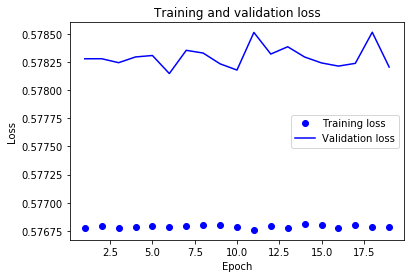

In [25]:
### Plot loss ###

loss = hist.history['loss'][1:]
val_loss = hist.history['val_loss'][1:]

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [26]:
### Evaluate model on test data###

model.evaluate(X_test, y_test)

89469/89469 [==============================] - 1s 14us/step


[0.5807740829072986, 0.8524069789549364]